# Environment setup 


## Installing CLIP and YoloV5 and Imports

It the first section of this file, the installation of the needed components is performed. These first bash lines install CLIP and YoloV5 respectively. These two Neural Network will represent the ground base of the project development.

In [ ]:
%%capture
%%bash
# Download CLIP and YOLO
pip install git+https://github.com/openai/CLIP.git
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

# Command to install some needed dependencies in the AWS machine
sudo apt-get update && sudo apt-get install ffmpeg libsm6 libxext6 -y

## List of imports

In [ ]:
# general imports
import pickle
import json
import tarfile
import os
import math
import torch
import clip
from PIL import Image, ImageFilter, ImageDraw

# utility libraries imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# torch imports
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms

## Setting the Clip model and Yolo model variables

In [ ]:
# Chosing the device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# choosing the clip model and the yolo versions, both pre-trained
clip_model, preprocess = clip.load('RN50', device)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True)

# Ensure the model is in float32 precision and transferred to the correct device
clip_model = clip_model.to(device).float()

## Dataset

The following code sections contain the needed structures to load the data from the refcoco dataset.\
The purpose of the Refcocog is Referring Expression Grounding, whose goal is to identify an object given a referring example. This is corresponds with the objective of this project.\
The dataset is composed of 25799 images, each having an average of 3.7 referring expression. These expression are related to specific objects inside the image. The Ground truth is represented by the bounding boxes.

The set of files composing the dataset is:
 - `instances.json` which contains all the information about the bunding boxes of each image
   example of instance
 - `ref(umd).p` which is a serialized file with all the description related to a bounding box and the split it belongs to (train/validation/test)
 - the `images directory` with all the images

This Dataset class, reads the instances.json and refs(umd).p files, creates an association image_id->image_name and annotation_id -> bounding_boxes to simplify the retrivial of the single element in the `__getitem__` method.\
Moreover, a set of samples is created with all the datase entries, each seample is composed of: image id, annotation id, and the sentence. The oobjective of this structure, besides contaioning all samples for the len() method, is to simplify the implementation of the getitem method.\
The latter takes as input an idx (which is the element currently being processed by the iterator) and return the image cropped to the bounding boxes and the sentence related with that box.\
the dataset can perform Data augmentation if needed, and can decide what to do with the bounding boxes depending on th crop_borders variable:
- `cut` -> simply cut the image to the bounding boxes
- `blur` -> blur what's outside the box
- `none` -> do nothing

The before being returned, the image is preprocessed using the clip preprocessing (self.transformation).\
The object returned by the `__getitem__` contains:
- the image path (for the BaseModel)
- the image (with eventually the modifications required)
- the sentence related to that image
- the bounding boxes (converted into coordinates)

In [ ]:
class RefCOCOgDataset(Dataset):
    def __init__(self, transform=None, split='train', device='cuda', crop_borders='cut'):

        ## Load images' management properties
        self.image_dir = os.path.join('refcocog', 'images')
        self.transform = transform
        self.crop_borders = crop_borders  # Can be 'cut', 'blur', or 'none'

        # Define class properties for split and device
        self.split = split
        self.device = device

        # Load dataset references and instances
        self.refs = self.load_refs()
        self.instances = self.load_instances()

        # Create lookup dictionaries for efficient indexing
        self.image_id_to_filename = {img['id']: img['file_name'] 
                                     for img in self.instances['images']}
        self.ann_id_to_bbox = {ann['id']: ann['bbox'] 
                               for ann in self.instances['annotations']}

        # Prepare samples for the dataset
        self.samples = self._prepare_samples()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load the image
        image_name = self.image_id_to_filename[sample['image_id']]
        image_path = os.path.join(self.image_dir, image_name)


        image = Image.open(image_path).convert("RGB")
        # Get the bounding box
        bbox = self.ann_id_to_bbox[sample['ann_id']]
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h

        if self.crop_borders == 'cut':
            # cut the image to the bounding box
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(image.size[0], x2), min(image.size[1], y2)
            image = image.crop((x1, y1, x2, y2))

        elif self.crop_borders == 'blur':
            # Blur the area outside the bounding box
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(image.size[0], x2), min(image.size[1], y2)

            # Create a blurred version of the image
            blurred_image = image.filter(ImageFilter.GaussianBlur(radius=15))

            # Create a mask to preserve the bounding box region
            mask = Image.new("L", image.size, 0)
            draw = ImageDraw.Draw(mask)
            draw.rectangle((x1, y1, x2, y2), fill=255)

            # Composite the image with the blurred background
            image = Image.composite(image, blurred_image, mask)

        # Apply preprocessing transforms
        if self.transform:
            image = self.transform(image)

        # Prepare the sample
        sample = {
            'image_path':image_path,
            'image': image,
            'sentence': sample['sentence'],
            'bbox': torch.Tensor([x1, y1, x2, y2])
        }
        return sample

    def load_refs(self):
        annotation_file = os.path.join('refcocog', 'annotations', 'refs(umd).p')
        with open(annotation_file, 'rb') as f:
            data = pickle.load(f)
        return [item for item in data if item['split'] == self.split]

    def load_instances(self):
        instances_file = os.path.join('refcocog', 'annotations', 'instances.json')
        with open(instances_file, 'r') as f:
            return json.load(f)

    def _prepare_samples(self):
        samples = []
        for ref in self.refs:
            for sentence in ref['sentences']:
                samples.append({
                    'image_id': ref['image_id'],
                    'ann_id': ref['ann_id'],
                    'sentence': sentence['sent']
                })
        return samples

# Fine-tuning Clip

## Dataloaders

For all the models, always three dataset will be instantiated, one for training, one for validation and one for test. Each step of course will use different parameters, in order to test what are the best options to train models.

For the fine tuning of CLIP, after different attempts with cropped immages, I decided to blur what is outside the bounding boxes. In such a way, clip can finetune keeping the information on the location of the boxes, and be slightly more resilient to overfitting, as images that could get cropped into too small format and result too altered after preprocessing would now be more easly understood by the network.

Each class is then loaded in a DataLoader wrapper. All these dataloader have been designed to work leveraging multithreading, with the goal of speeding up training and validation.\
It is important to point out that while the train set is shuffled, the validation and test set are not, since it would be pointless to shuffle them. \
Moreover, data are split in batches whose size is `64`. This parameter has also been chosen for speed reason, and 64 elements batches represent a good trade-of, since batches are nor too large or too small, and the update of the weights happens after a reasonable amount of examples (given the dataset size).

In [ ]:
# Train, validation, and test dataset blurring what's outside the boxes in the train set trying to avoid overfitting
finetune_train_dataset = RefCOCOgDataset(transform=preprocess, split='train', crop_borders='crop')
finetune_val_dataset = RefCOCOgDataset(transform=preprocess, split='val', crop_borders='crop')
finetune_test_dataset = RefCOCOgDataset(transform=preprocess, split='test', crop_borders='crop')

# DataLoader options
batch_size = 64
num_workers = 4
pin_memory = True
persistent_workers = True

# DataLoaders
finetune_train_loader = DataLoader(
    dataset=finetune_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

finetune_val_loader = DataLoader(
    dataset=finetune_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

finetune_test_loader = DataLoader(
    dataset=finetune_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

# Print dataset sizes
print("=======================================================")
print(f"Number of training samples: {len(finetune_train_dataset)}")
print(f"Number of validation samples: {len(finetune_val_dataset)}")
print(f"Number of test samples: {len(finetune_test_dataset)}")
print("=======================================================")

## Train and validation functions

The training and loop functions have been implemented for both pre-train.

The `train_epoch` function iterates through the batches. For each one, the images and tokenized text sentences are passed through the model to obtain their respective feature embeddings. These embeddings are normalized to unit vectors to ensure a stable similarity measure, which is calculated using the dot product between image and text features. The similarity matrix reflects how well each image aligns with each text, guiding the model’s learning. The cross-entropy loss is computed using the similarity matrix, where the labels correspond to the correct image-text pairs. This contrastive loss is computed in both directions (image-to-text and text-to-image), ensuring that both modalities are equally optimized to match each other. The two losses are averaged, and gradients are backpropagated through the model using the optimizer. Gradient clipping is applied to prevent gradients from becoming too large, ensuring stable training. The accuracy is calculated by comparing the predicted alignment (i.e., the most similar image-text pair) to the true labels. For each batch, the function determines the index of the maximum similarity in the similarity matrix, which corresponds to the predicted match. If the predicted match is correct (i.e., the index matches the label), the prediction is considered accurate. The correct predictions are accumulated, and the total accuracy is updated by dividing correct predictions by the total number of samples processed.

The `validate` function performs similar steps, but without updating the model’s weights. It evaluates the model on a validation set by calculating the same similarity metric, contrastive loss, and accuracy as in training, providing an assessment of how well the model generalizes to unseen data.



In [ ]:
def train_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch in pbar:
        images = batch['image'].to(device)
        texts = clip.tokenize(batch['sentence']).to(device)

        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        image_features, text_features = model(images, texts)

        # Similarity matrix
        similarity = image_features @ text_features.t()

        # Labels for contrastive learning
        labels = torch.arange(len(images)).to(device)

        # Calculate loss
        loss_i2t = F.cross_entropy(similarity, labels)
        loss_t2i = F.cross_entropy(similarity.t(), labels)
        loss = (loss_i2t + loss_t2i) / 2

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate accuracy
        predictions = similarity.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += len(images)
        total_loss += loss.item()

        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct_predictions / total_samples:.2f}%'
        })

    return total_loss / len(train_loader), correct_predictions / total_samples



def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            images = batch['image'].to(device)
            texts = clip.tokenize(batch['sentence']).to(device)

            # Forward pass
            image_features, text_features = model(images, texts)

            # Similarity matrix
            similarity = image_features @ text_features.t()

            # Labels for contrastive learning
            labels = torch.arange(len(images)).to(device)

            # Calculate loss
            loss_i2t = F.cross_entropy(similarity, labels)
            loss_t2i = F.cross_entropy(similarity.t(), labels)
            loss = (loss_i2t + loss_t2i) / 2

            # Calculate accuracy
            predictions = similarity.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += len(images)
            total_loss += loss.item()

    # Return average loss and accuracy for validation
    return total_loss / len(val_loader), correct_predictions / total_samples


## Print results function

This function is used to store the results of the pretraining into an image in a folder dedicated to either Default model (bare CLIP) or the custom CLIP model

In [ ]:
def plot_training_curves(num_epochs, training_losses, validation_losses,
                         training_accuracies, validation_accuracies,
                         lr, output_folder='finetuning2'):

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', marker='o', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy', marker='o', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    image_name = f'{output_folder}/training_{num_epochs}_{lr}.png'
    plt.savefig(image_name)
    plt.close()

    print(f"Plot saved as {image_name}")

## 1. Default CLIP model

### Train and validation loop
The training loop runs the train function over the train dataloader and then runs the validation function to check the performances of the model in order to see eventual overfit.\
In this process various learning rates have been used, as coming across overfitting is pretty easy, and finding the best learning rate that can finetune CLIP preserving its pretreining information is not easy.\
However, the lr that seems to have the best performance is `1e-7`.\
As it can be seen from the code, different optimizer with different settings and learning rates were tested, but running into overfitting resulted very commond and difficult to avoid. Therefore, trying to avoiding this, different techniques were applied (on on the dataset, on the loop and on the train function):
- gradient clipping
- learning rate scheduling with `CosineAnnealingLR` to decrease the lr each epoch
- early stopping (to store the best model)

Given the size of the dataset and the depth of the clip model, the number of epochs is set to `10`.

Reminding that the notebook was executed in a `ml.g4dn.xlarge` aws machine (the most powerful allowed as reported in the course's slides), the train for each epoch took about 22 minutes.

Trying to achieve better result, another model has been implemented below. 


In [ ]:
# Learning rate and optimizer
lr=1e-7
# # optimizer = Adam(clip_model.parameters(), lr=1e-3) # Overfit
# # optimizer = Adam(clip_model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.02) # Overfit
# # optimizer = Adam(clip_model.parameters(), lr=5e-6, betas=(0.9, 0.98), weight_decay=0.02) # Overfit
# # optimizer = Adam(clip_model.parameters(), lr=1e-6, betas=(0.9, 0.98), weight_decay=0.02) # Overfit
# optimizer = Adam(clip_model.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.1)

# Training loop
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Values to get the best model
best_val_loss = float('inf')
patience = 3
patience_counter = 0


# Initialize optimizer
optimizer = Adam(
    clip_model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    weight_decay=0.1
)

# Scheduler for the learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=2
)

# Number of epochs for training
num_epochs = 10

# Best model's name
best_model_name = f'best_clip_{lr}.pth'

# Training loop
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # Train and Validate for one epoch
    train_loss, train_accuracy = train_epoch(
        clip_model,
        finetune_train_loader,
        optimizer,
        device,
        epoch
    )

    val_loss, val_accuracy = validate(
        clip_model,
        finetune_val_loader,
        device
    )

    # Step the learning rate scheduler
    scheduler.step()

    # Store losses for plotting
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

    # Model checkpoint and early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': clip_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        }, best_model_name)
    else:
        patience_counter += 1

    # Print epoch metrics
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')
    print(f'Current LR: {optimizer.param_groups[0]["lr"]:.2e}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break


# Save learning curve in an image
plot_training_curves(num_epochs,
                     training_losses,
                     validation_losses,
                     training_accuracies,
                     validation_accuracies,
                     lr,
                     output_folder='finetuning1')

### Test

In [ ]:
test_loss, test_accuracy = validate(clip_model, finetune_test_loader, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

### Results
<div style="text-align: center;">
    <h3>Comparison of Blurred and Cropped Images</h3>
</div>
<div style="display: flex; justify-content: space-between;">
    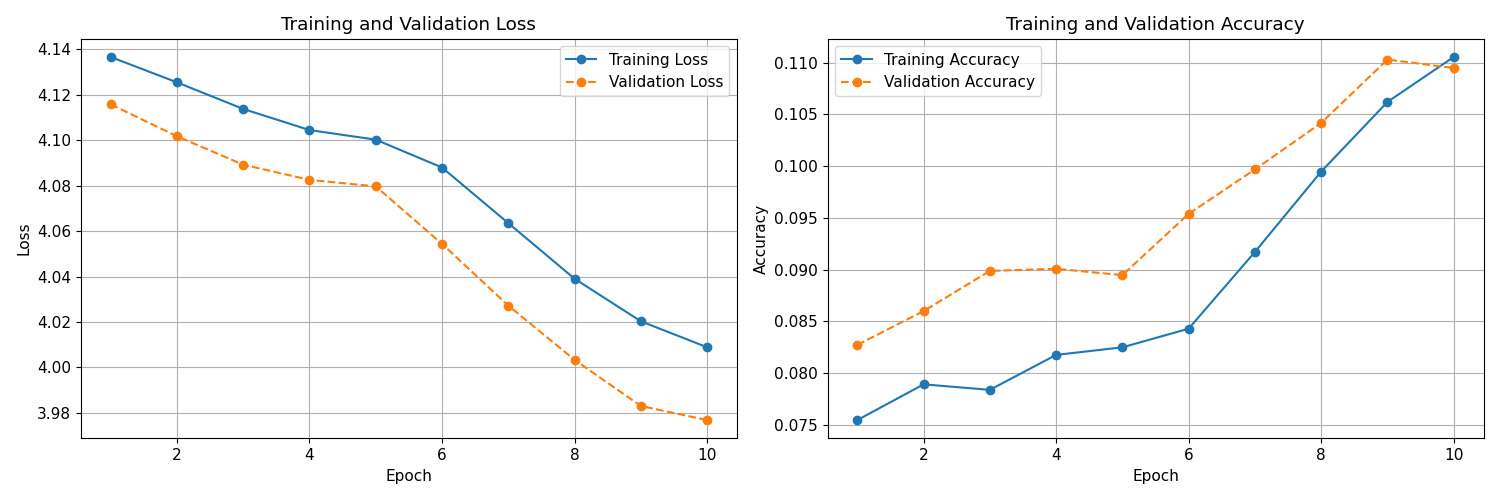
    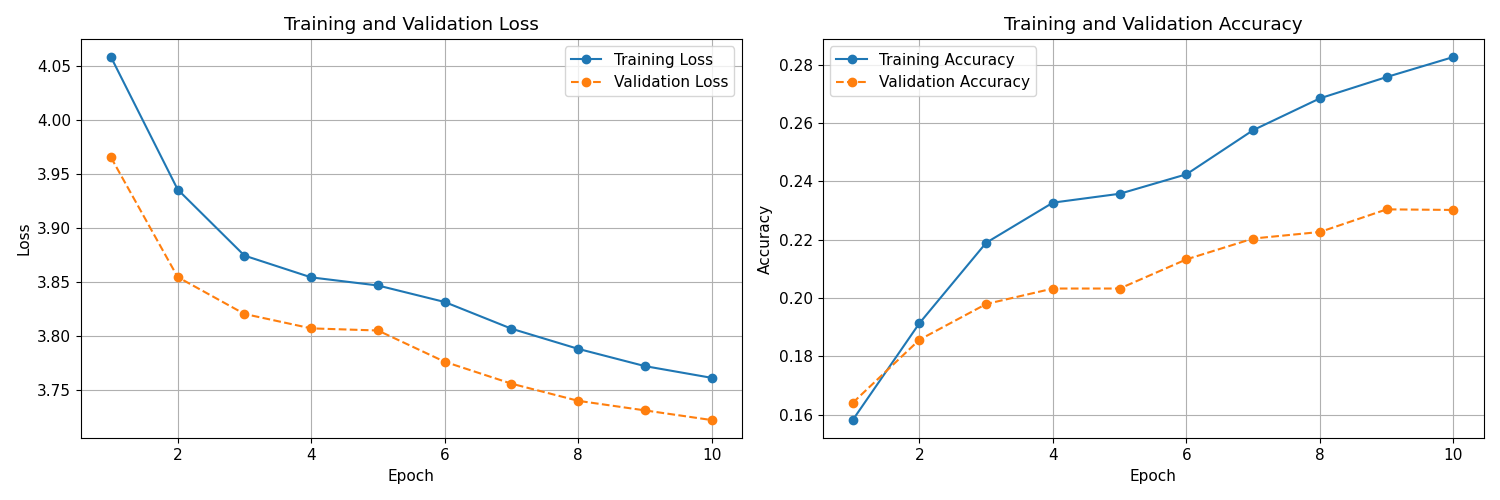
</div>

Results show not really promising curves. The Two images on the left refers to the finetune using blurred borders around the bounding boxes. Here we can see that the reduction of the loss does not follow a typical expected progression, being lower and almost costant up until epoch 5 and decreasing  even faster afterwards. The pretrain with the cropped images (two graphs on the right) shows a bette curve, but train stil get a slow down around epoch 5 to then start lowering again.\
From what I can see, these images suggest that more epochs would benefit the finetuning process, but since the training time is already very long, and the expected increase of performance would not be really huge in my point of view, I decided to stop here and try another approach.


## 2. Custom CLIP model
After trying different parameters for the learning rate, to avoid overfitting while still trying to improve the error loss on the validation set, I decided to try change of approach.\
I decided to add a projection layer at the end of CLIP. The idea is to define a new model that does the image and text encoding, then apply a linear layer at the and, and again train the network, allowing the last layer to be fully trained by the refcocog images.

The final goal is of course to obtain better results than the bare clip fine-tuning above.

### Model

In [ ]:
class CLIPGrounding(nn.Module):
    def __init__(self, clip_model, inhibit_added_layer=False):
        super().__init__()
        self.clip_model = clip_model
        self.clip_dim = self.clip_model.visual.output_dim

        # Add a projection layer
        self.projection = nn.Linear(self.clip_dim, self.clip_dim)

        if inhibit_added_layer:
            self.projection.weight.data = torch.eye(self.clip_dim)
            self.projection.bias.data.zero_()

    def forward(self, images, texts):
        # Encode images and text with CLIP

        # with torch.no_grad(): # Uncomment to train CLIP
        image_features = self.clip_model.encode_image(images)
        text_features = self.clip_model.encode_text(texts)

        # Simple projection
        image_features = self.projection(image_features)
        text_features = self.projection(text_features)

        return image_features, text_features

### Train and validation loop

The training loop fine-tunes a CLIP-based model for visual grounding, using separate learning rates for the CLIP model and its projection layers to prevent overfitting. The model is initialized using the `CLIPGrounding` class and moved to the correct device. The learning rate for the CLIP model is set to a small value of `1e-7` to allow for fine-tuning (and avoid loosing pre-trained weights), while the projection layer has a higher learning rate of `1e-4` to focus on enhancing its training.

The optimizer used is `AdamW` (Similar to Adam but with a better implementation of weight decay), which is configured with weight decay and epsilon values for both the CLIP model and the projection layer to ensure stable training. To adjust the learning rate dynamically during training, the loop uses a `CosineAnnealingLR` lr scheduler.

Each epoch consists of training and validation. During the training phase, the `train_epoch()` function computes the training loss and accuracy. Afterward, the model is validated using the `validate()` function to calculate the validation loss and accuracy. These metrics are tracked throughout the training process, with training and validation losses and accuracies stored in separate lists.

At the end of each epoch, the learning rate scheduler updates the learning rate based on the cosine annealing strategy. The model is then saved if it achieves the best validation accuracy seen so far, ensuring the best model is kept. After training is complete, the results are visualized through training curves, and the model’s state is saved for future use, enabling continued evaluation or deployment.


In [ ]:
# Learning rates form smallest to highest
# lrs = [1e-6, 1e-5, 1e-4]


# for lr in lrs:

# Create model
ft_clip_model = CLIPGrounding(clip_model).to(device)

# Print lr iteration information
# print(f'Learning rate = {lr}:')

# number of epochs for each learnig rate
num_epochs = 10
lr_clip = 1e-7
lr_proj = 1e-4

# Best model's name
best_model_name = f'best_CLIPGrounding_{num_epochs}_{lr_clip}_{lr_proj}.pth'

# Initialize different lr for clip to avoid overfitting
# while enhancing train on projection layer.
optimizer = torch.optim.AdamW(
    params=[
        {
            "params": ft_clip_model.clip_model.parameters(),
            "lr": lr_clip,
            "weight_decay": 0.01,
            "eps": 1e-8
        },
        {
            "params": ft_clip_model.projection.parameters(),
            "lr": lr_proj,
            "weight_decay": 0.01,
            "eps": 1e-8
        }
    ]
)

# optimizer = torch.optim.AdamW(ft_clip_model.parameters(), lr=1e-4, weight_decay=0.01, eps=1e-8)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs
)

# Lists to store metrics
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Train/validation loop
for epoch in range(1, num_epochs+1):
    # Train epoch
    train_loss, train_acc = train_epoch(
        ft_clip_model, finetune_train_loader, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(ft_clip_model, finetune_val_loader, device)

    # Store metrics
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    # Update learning rate
    scheduler.step()

    # Print metrics
    print(f'Epoch {epoch}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

torch.save({
    'epoch': epoch,
    'ft_clip_model_state_dict': ft_clip_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, best_model_name)

# Save learning curve in an image
plot_training_curves(num_epochs,
                     training_losses,
                     validation_losses,
                     training_accuracies,
                     validation_accuracies,
                     lr_clip,
                     output_folder='finetuning2')

### Test

In [ ]:
# Test
test_loss, test_acc = validate(ft_clip_model, finetune_test_loader, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

<div>
    <h3>Results with Cropped Images</h3>
</div>
<div style="display: flex; justify-content: space-between;">
    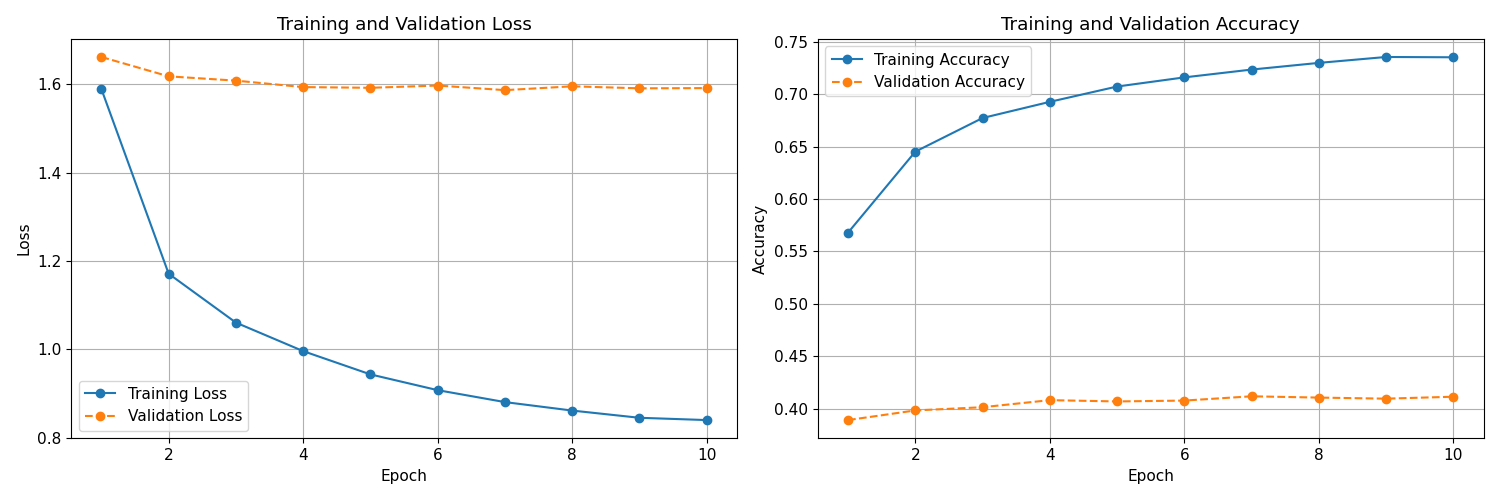
</div>

The training has been executed only on the cropped images as they perform better with CLIP. The training error decreases exponentially starting from a value around 1.6 to end close to 0.8. However the error on the validation set sees very slight improvements throughoput the epochs, going hardly below 1.6. Indeed after already 5 epochs the accuracy on the validation starts oscillating, suggesting overfit.\
For this reason, I decided to stop here for the pretrain phase, and focus on the next steps moving onto the models, which are the main focus of the project. I expected better result, but I decided to use this finetune model in the custom visual grounding model implemeted below. I am aware that this may cause a sensible reduction in the expressive power of the model, but I haven't been able to improve the pre-train any further.

# Models 

## Dataloaders

Since the goal of this model is to predict bounding boxes of an object in a picture from a textual description, new Dataset classes are created without any crop to the images and applying only the clip preprocessing

In [ ]:
# Train, test, and validation set split cropping images, without applying any transformation 
train_dataset = RefCOCOgDataset(transform=preprocess, split='train', crop_borders='none')
val_dataset = RefCOCOgDataset(transform=preprocess, split='val', crop_borders='none')
test_dataset = RefCOCOgDataset(transform=preprocess, split='test', crop_borders='none')

# DataLoaders batch size and other options. Computation is done with 4 workers to speed it up
batch_size = 64
shuffle = True
pin_memory = True
num_workers = 4
persistent_workers = True

# DataLoader, shuffled in case of training set and not shuffled in case of test and validation sets
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

# Print dataset sizes
print("=======================================================")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print("=======================================================")

## Loss function

While thinking about what could be a suitable function to minimize in order to train the network, I decided to look into already existing models. For this reason I started looking into YOLO error functions, finding out that its most recent version uses particular implementations of `IoU` (Intersection over Union).

IoU itself aims to calculate the intersection of the two images and their union, and then subdivides the first by the second hence returning a value always between 0 and 1. It can represent a good metrics for evaluation as it gives a numerical idea of how close the prediction and ground truth boxes are, and if used in the form of `1-IoU` it can be used in a minimization problem. However it presents some important drawbacks:
- when the boxes are close, the derivative of the function becomes small making harder for the optimizer to understand when the model is performing well
- if the boxes are small, and the shape of the predicted box is a bit smaller than the ground truth, IoU might drop leading to large gradients and unstable training

So, while looking through the various versions of IoU (Generalized IoU, Distance IoU, Complete IoU), I found out that a good fit as error measure could be the Efficient IoU called `EIoU` [[reference](https://medium.com/@cshyo1004/iou-and-variants-overview-a328acf177cd)], an implementation of IoU that breaks down the error into 3 main components:

- `IoU` -> measures the overlap between the predicted and ground truth boxes
- `Distance Penalty` -> penalizes the normalized squared Euclidean distance between the centroids of the predicted and ground truth boxes. This is calculated as the ratio of the squared distance between centers to the squared diagonal length of the smallest enclosing box
- `Aspect Ratio Penalty` -> penalizes mismatches in the width-to-height ratios of the bounding boxes, calculated using the arctangent of the width-to-height ratio difference

EIoU helps achieve better regression by considering both the overlap and geometric factors of the bounding boxes. The distance term helps improve localization accuracy, while the aspect ratio term helps maintain proper box shapes. The normalization of the distance penalty by the enclosing box diagonal makes the metric scale-invariant, helping with both large and small objects. By combining these terms, EIoU provides more informative gradients for optimization compared to standard IoU, especially when boxes are close to overlapping or when dealing with small objects.

Here a class has been defined to implement this loss function that will be used to train the models. This class leverages functions to calculate IoU (which will be also used as evaluation metric) and EIoU itself.

In [ ]:
def compute_iou(boxes1, boxes2):

    # Calculate intersection coordinates
    x1 = torch.max(boxes1[:, 0], boxes2[:, 0])
    y1 = torch.max(boxes1[:, 1], boxes2[:, 1])
    x2 = torch.min(boxes1[:, 2], boxes2[:, 2])
    y2 = torch.min(boxes1[:, 3], boxes2[:, 3])

    # Calculate intersection area
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Calculate union area
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union = area1 + area2 - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-6)  # Add small epsilon

    return iou

def compute_eiou(boxes1, boxes2):

    iou = compute_iou(boxes1, boxes2)

    # Calculate centers for both sets of boxes
    boxes1_cx = (boxes1[:, 0] + boxes1[:, 2]) / 2
    boxes1_cy = (boxes1[:, 1] + boxes1[:, 3]) / 2
    boxes2_cx = (boxes2[:, 0] + boxes2[:, 2]) / 2
    boxes2_cy = (boxes2[:, 1] + boxes2[:, 3]) / 2

    # Calculate widths and heights
    boxes1_w = boxes1[:, 2] - boxes1[:, 0]
    boxes1_h = boxes1[:, 3] - boxes1[:, 1]
    boxes2_w = boxes2[:, 2] - boxes2[:, 0]
    boxes2_h = boxes2[:, 3] - boxes2[:, 1]

    # Central point distance term
    c_2 = torch.pow(boxes2_cx - boxes1_cx, 2) + torch.pow(boxes2_cy - boxes1_cy, 2)

    # Diagonal length of the smallest enclosing box
    d_2 = torch.pow(torch.max(boxes1[:, 2], boxes2[:, 2]) - torch.min(boxes1[:, 0], boxes2[:, 0]), 2) + \
          torch.pow(torch.max(boxes1[:, 3], boxes2[:, 3]) - torch.min(boxes1[:, 1], boxes2[:, 1]), 2)

    # Distance penalty
    distance_penalty = c_2 / (d_2 + 1e-7)

    # Aspect ratio penalty
    boxes1_aspect = torch.atan2(boxes1_w, boxes1_h)
    boxes2_aspect = torch.atan2(boxes2_w, boxes2_h)
    aspect_penalty = torch.pow(boxes1_aspect - boxes2_aspect, 2) / 4

    # Final EIoU
    eiou = iou - distance_penalty - aspect_penalty

    return eiou

class EIoULoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, pred_boxes, target_boxes):
        # print("pred_boxes ",pred_boxes)
        # print("target_boxes ",target_boxes)
        eiou_loss = 1 - compute_eiou(pred_boxes, target_boxes)

        if self.reduction == 'mean':
            return eiou_loss.mean()
        elif self.reduction == 'sum':
            return eiou_loss.sum()
        else:
            return eiou_loss

## Metric functions 
The first function, `calculate_metrics` is desaigned to calculate performances of both models ad represents the commond ground for evaluation. It computes the performance of the model by comparing predicted bounding boxes (`pred_boxes`) against target bounding boxes (`target_boxes`). The function calculates the Intersection over Union (IoU) for all predictions using the `compute_iou` function, which measures the overlap between predicted and target boxes. From this, it derives the **localization accuracy**, defined as the proportion of predictions with an IoU greater than 0.5, indicating how well the model localizes objects. Additionally, it computes the **grounding accuracy**, which is essentially the recall of predictions with IoU > 0.5 relative to the total number of target boxes, providing insight into the model's ability to correctly identify objects. If feature vectors (`pred_features` and `target_features`) are provided, the function also calculates the **semantic similarity** using cosine similarity, which measures how closely the predicted and target features align in the feature space. Finally, it computes the `mean IoU`, which is the average IoU across all predictions, giving an overall measure of localization performance. All these metrics are returned as a dictionary, making it easy to track and compare model performance.

The second function, `display_metrics`, takes the metrics dictionary produced by `calculate_metrics` and prints them in a structured and readable format.

In [ ]:
def calculate_metrics(pred_boxes, target_boxes, pred_features=None, target_features=None):

    metrics = {}

    # Move tensors to CPU
    pred_boxes = pred_boxes.cpu()
    target_boxes = target_boxes.cpu()

    # Calculate IoU for all predictions
    ious = compute_iou(pred_boxes, target_boxes)

    # Localization Accuracy (IoU > 0.5)
    localization_accuracy = torch.mean((ious > 0.5).float()).item()
    metrics['localization_accuracy'] = localization_accuracy

    # Grounding Accuracy (recall with IoU > 0.5)
    true_positives = torch.sum(ious > 0.5).item()
    total_targets = len(target_boxes)
    grounding_accuracy = true_positives / total_targets if total_targets > 0 else 0
    metrics['grounding_accuracy'] = grounding_accuracy

    # Semantic Similarity using cropped image embeddings
    if pred_features is not None and target_features is not None:
        pred_features = pred_features.cpu()
        target_features = target_features.cpu()
        semantic_similarity = F.cosine_similarity(pred_features, target_features).mean().item()
        metrics['semantic_similarity'] = semantic_similarity

    # Calculate mean IoU
    metrics['miou'] = ious.mean().item()

    return metrics

def display_metrics(metrics, epoch=None, split="test"):

    print("\n" + "===============================================")
    if epoch is not None:
        print(f"Epoch {epoch} - {split.capitalize()} Metrics:")
    else:
        print(f"{split.capitalize()} Metrics:")
    print("="*50)

    if "loss" in metrics:
        print(f"Loss: {metrics['loss']:.4f}")
    if "localization_accuracy" in metrics:
        print(f"Localization Accuracy: {metrics['localization_accuracy']:.2%}")
    if "grounding_accuracy" in metrics:
        print(f"Grounding Accuracy: {metrics['grounding_accuracy']:.2%}")
    if "semantic_similarity" in metrics:
        print(f"Semantic Similarity: {metrics['semantic_similarity']:.4f}")
    if "miou" in metrics:
        print(f"Mean IoU: {metrics['miou']:.2%}")

    print("===============================================")

## Crop and encoding function

this funciton is used to compute the cropping and embedding of functions in order to be able to compute the semantic similarity of what the predicted bounding boxes find. If the bounding boxes are not valid (which can happen with BaseModel if yolo finds no bounding boxes), the function appends a zero tensor. 

In [ ]:
# crop immages
def crop_and_encode_images(image_paths, pred_boxes, model, device, preprocess=preprocess):
    cropped_embeddings = []
    embedding_dim = 1024 

    for img_path, bbox in zip(image_paths, pred_boxes):
        # Load image
        image = Image.open(img_path).convert("RGB")

        # Convert tensor to list
        x1, y1, x2, y2 = bbox.int().tolist()

        # Validate bounding box (ensure positive width and height)
        if x2 > x1 and y2 > y1:
            cropped_img = image.crop((x1, y1, x2, y2))
            # Preprocess for CLIP
            cropped_tensor = preprocess(cropped_img).unsqueeze(0).to(device)

            # Extract embedding
            with torch.no_grad():
                cropped_embedding = model.encode_image(cropped_tensor).float()
        else:
            cropped_embedding = torch.zeros((1, embedding_dim)).to(device)  # Return zero tensor
        
        cropped_embeddings.append(cropped_embedding)

    return torch.cat(cropped_embeddings, dim=0)

## 1. Base Model

### Model definition

The `BaseModel` is defined as a starting point to further study the task and become familiar with this visual grounding task. The approach described in the project statement is to combine YOLO with CLIP, taking the bounding boxes computed by the first and find the most similar to the description using the second.

This model has been created using `YOLO V5`, and takes objects recognized with a confidence higher than `0.4`. Images for which no bounding box has been found are skipped, and they're grouped in a variable that tells how many they are. However, It has been observer that images with no bounding boxes are really a few.

Once YOLO has the bounding boxes, they are used to get the cropped images, which are preprocessed using `process_crops_for_clip`, which applies the CLIP needed preprocess. Once this is done the embeddings for the cropped immages and the text description are computed with CLIP and compared with cosine similarity to get the bounding box that matches the description the best As mentioned, the forward model also returns an object keepoing tracks of the paths and count of immages with no objects recognized (around 50).

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, yolo_model, clip_model, confidence_threshold=0.4, transform=None, device="cuda"):
        super().__init__()

        # Initialize class' variables
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.transform = transform

        # Initialize class' models
        self.yolo_model = yolo_model
        self.clip_model = clip_model
        self.yolo_model.conf = confidence_threshold
        self.yolo_model.to(device)
        self.clip_model.to(device)

    def forward(self, images_paths, descriptions):

        # Lists to store results for the batch
        batch_best_boxes = []
        batch_best_scores = []
        images_producing_no_bbox = {
            "paths": [],
            "count": 0
        }
        # Process each image in the batch
        for idx in range(len(images_paths)):
            image_path = images_paths[idx]
            description = descriptions[idx]

            # Get all objects with YOLO inference
            with torch.no_grad():

                # Get yolo objects
                yolo_results = self.yolo_model(image_path)
                crops = yolo_results.crop(save=False)

                # Extract bounding boxes
                boxes = [torch.tensor(crop['box'], device=self.device) for crop in crops]

                # Prepare crops for CLIP
                crops = process_crops_for_clip(crops, transform=self.transform, device=self.device)


            # Convert list to batch tensor
            if crops is not None and len(crops) > 0:
                # Encode text description
                with torch.no_grad():
                    description_tokens = clip.tokenize(description).to(self.device)
                    description_embedding = self.clip_model.encode_text(description_tokens).float()
                    object_embeddings = self.clip_model.encode_image(crops).float()

                # Calculate similarities for all objects at once
                similarities = torch.cosine_similarity(
                    object_embeddings,
                    description_embedding.repeat(len(object_embeddings), 1),
                    dim=1
                )

                # Find best match
                best_match_index = similarities.argmax()
                best_match_box = boxes[best_match_index]
                best_match_score = similarities[best_match_index]
            else:
                # Handle case where transform failed for all objects
                best_match_box = torch.zeros(4, device=self.device)
                best_match_score = torch.tensor(0.0, device=self.device)
                images_producing_no_bbox["paths"].append(image_path)
                images_producing_no_bbox["count"] += 1

            batch_best_boxes.append(best_match_box)
            batch_best_scores.append(best_match_score)

        # Stack results into tensors
        pred_boxes = torch.stack(batch_best_boxes)

        return pred_boxes,  images_producing_no_bbox


def process_crops_for_clip(crops, transform=None, device='cuda'):

    processed_crops = []
    for crop in crops:
        # Extract image from crop dictionary
        if isinstance(crop, dict) and 'im' in crop:
            crop_img = crop['im']
        else:
            crop_img = crop

        # Convert numpy array to PIL Image if necessary
        if isinstance(crop_img, np.ndarray):
            crop_img = Image.fromarray(crop_img)

        # Process the image with the provided transform
        if transform is not None:
            processed_crop = transform(crop_img).to(device)
            processed_crops.append(processed_crop)

    # Stack all processed crops into a batch
    if processed_crops:
        return torch.stack(processed_crops)
    return None

### Validation and test functions

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    num_batches = len(dataloader)

    localization_correct = 0
    total_samples = 0
    total_no_bbox_images = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, total=num_batches, desc='Validation')
        for batch in pbar:
            # Get preprocessed data from dataset
            images = batch["image_path"]
            texts = batch["sentence"]
            target_boxes = batch["bbox"].to(device, non_blocking=True)

            # Forward pass - unpack the tuple
            pred_boxes, no_bbox_info = model(images, texts)

            # Update the loss function call to include similarity scores
            loss = criterion(pred_boxes, target_boxes)

            # Update metrics
            total_loss += loss.item()
            all_preds.append(pred_boxes.cpu())
            all_targets.append(target_boxes.cpu())

            # Calculate IoU for localization accuracy
            ious = compute_iou(pred_boxes, target_boxes)
            localization_correct += (ious > 0.5).sum().item()
            total_samples += len(images)

            # Update total_no_bbox_images with the count from model output
            total_no_bbox_images += no_bbox_info["count"]

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'localization_accuracy': f'{localization_correct / total_samples:.4f}',
                'total_no_bbox_images': f'{total_no_bbox_images}'
            })


def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = len(test_loader)

    all_preds = []
    all_targets = []
    all_pred_features = []
    all_target_features = []

    total_samples = 0
    total_no_bbox_images = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, total=num_batches, desc='Testing')
        for batch in pbar:

            images_paths = batch["image_path"]
            texts = batch["sentence"]
            target_boxes = batch["bbox"].to(device, non_blocking=True)

            # Forward pass 
            pred_boxes, no_bbox_info = model(images_paths, texts)

            loss = criterion(pred_boxes, target_boxes)

            # Get text embeddings
            text_tokens = clip.tokenize(texts).to(device)
            text_embeddings = model.clip_model.encode_text(text_tokens).float()

            # Extract cropped image embeddings
            cropped_embeddings = crop_and_encode_images(images_paths, pred_boxes, model.clip_model, device)

            # Store predictions and targets
            all_preds.append(pred_boxes.cpu())
            all_targets.append(target_boxes.cpu())
            all_pred_features.append(cropped_embeddings.cpu())  # Uses cropped images
            all_target_features.append(text_embeddings.cpu())  # Original text embeddings

            total_samples += len(images_paths)
            total_loss += loss.item()
            total_no_bbox_images += no_bbox_info["count"]

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'total_no_bbox_images': f'{total_no_bbox_images}'
            })

    if all_preds and all_targets:
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        all_pred_features = torch.cat(all_pred_features, dim=0)
        all_target_features = torch.cat(all_target_features, dim=0)

        # Calculate final metrics
        metrics = calculate_metrics(
            all_preds, 
            all_targets,
            all_pred_features,
            all_target_features
        )

        metrics['loss'] = total_loss / num_batches
        metrics['total_no_bbox_images'] = total_no_bbox_images

        return metrics

    return {
        'loss': float('inf'),
        'localization_accuracy': 0,
        'grounding_accuracy': 0,
        'semantic_similarity': 0,
        'miou': 0,
        'total_no_bbox_images': total_no_bbox_images
    }


### Model test

In [ ]:
# Initialize model, criterion, optimizer
base_model = BaseModel(yolo_model, clip_model, transform=preprocess)
criterion = EIoULoss()

# Test the model on the validation and test set
val_metrics = validate(base_model, val_loader, criterion, device)
test_metrics = test(base_model, test_loader, criterion, device)

display_metrics(test_metrics, split="test")

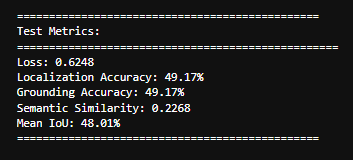

## 2.  Custom Model

### Model definition

`CustomModel` implements thge visual grounding architecture for this project. The approach is to implement a simple model that can obtain meaningful results. it uses the `CLIPGrounding` model for extracting features. These features are thgen concatenated and passed to the MLP that will extract the bounding boxes. This MLP is composed of three fully connected layers, with batch normalization and LeakyReLU activation functions in between. These layers progressively reduce the dimensionality of the feature vector while refining the information needed for accurate bounding box estimation.

Since bounding box predictions must remain within the bounds of the image, sigmoid activation function is applied to the output, ensuring values remain between 0 and 1. These normalized predictions are then scaled according to the dimensions of the original image, converting them into real-world coordinates.

Important is to point out that the model trains only the MLP, as the CLIP model is already pretrained.

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, clip_grounding_model, device='cuda'):
        super().__init__()

        # Model variables
        self.clip_grounding_model = clip_grounding_model
        self.device = device
        self.hidden_dim = self.clip_grounding_model.clip_dim

        input_dim = self.hidden_dim * 2
        out_dim = 4

        # MLP for bounding box prediction
        self.bbox_mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim // 8),
            nn.BatchNorm1d(input_dim // 8), 
            nn.LeakyReLU(0.1),
            nn.Linear(input_dim // 8, input_dim // 32),
            nn.BatchNorm1d(input_dim // 32), 
            nn.LeakyReLU(0.1),
            nn.Linear(input_dim // 32, out_dim)
        )


    def forward(self, images, texts):
        batch_size, _, img_h, img_w = images.shape

        with torch.no_grad():
            image_features, text_features = self.clip_grounding_model(images, texts)

        # # Normalize features
        # image_features = F.normalize(image_features, p=2, dim=-1)
        # text_features = F.normalize(text_features, p=2, dim=-1)

        # Concatenate features
        combined_features = torch.cat([image_features, text_features], dim=-1)

        # Predict bounding boxes
        pred_boxes = self.bbox_mlp(combined_features)

        # Scale bounding boxes to image size
        image_size = torch.tensor([img_w, img_h, img_w, img_h], device=pred_boxes.device).unsqueeze(0) 
        pred_boxes = torch.sigmoid(pred_boxes).clone() * image_size


        return pred_boxes

    # def get_embeddings(self, images, texts):
    #     text_tokens = clip.tokenize(texts).to(self.device)
    #     text_embeddings = self.clip_grounding_model.clip_model.encode_text(text_tokens).float()
    #     images_embeddings = self.clip_grounding_model.clip_model.encode_image(images).float()

    #     return images_embeddings, text_embeddings

### Train, validation, and test functions

The train, validation and test functions are pretty similar to the ones used for the baseModel, with some differences dued to the modes themselves. 
the `train_epoch`  function takes the data from the dataset, and feed them into the model obtaining the bounding boxes. These loss is then computed using `criterion` passed as a parameter and propagated in the network upwards. Gradient clipping is used to optimize the training. 

The `validate` function does something really similar, but using the `with torch.no_grad():`. It then computes the localization accuracy using the `compute_iou` function and considering correct all those ious witha value above `0.5`.

Again, the `test` function does thge same as the validation, but it also appends all the measures to arrays that willbe used to calculate the overall metrics and gets the embeddings that will be used to compute the semantic similarity. If `all_preds` and `all_targets` have been populatet, the metrics are computed using `calculate_metrics`, concatenating the loss and returning it to the executor.


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)

    pbar = tqdm(dataloader, total=num_batches, desc='Training')

    for batch in pbar:

        images = batch["image"].to(device, non_blocking=True)
        texts = clip.tokenize(batch["sentence"]).to(device)
        target_boxes = batch["bbox"].to(device, non_blocking=True)


        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        pred_boxes = model(images, texts)

        # print("target_boxes: ",target_boxes)
        # print("pred_boxes: ",pred_boxes)

        # Compute loss
        loss = criterion(pred_boxes, target_boxes)

        # Backpropagation
        loss.backward()
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #        print(f"{name}: {param.grad.abs().mean():.6f}")

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Track loss
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / num_batches if num_batches > 0 else float("inf")

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    num_batches = len(dataloader)

    with torch.no_grad():
        pbar = tqdm(dataloader, total=num_batches, desc='Validation')

        for batch in pbar:
            images = batch["image"].to(device, non_blocking=True)
            texts = clip.tokenize(batch["sentence"]).to(device)
            target_boxes = batch["bbox"].to(device, non_blocking=True)

            # Forward pass
            pred_boxes = model(images, texts)
            loss = criterion(pred_boxes, target_boxes)

            # Store results
            total_loss += loss.item()
            all_preds.append(pred_boxes.cpu())
            all_targets.append(target_boxes.cpu())

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Compute metrics
    if all_preds and all_targets:
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        ious = compute_iou(all_preds, all_targets)
        localization_accuracy = torch.mean((ious > 0.5).float()).item()

        return total_loss / num_batches if num_batches > 0 else float("inf"), {
            "localization_accuracy": localization_accuracy
        }

    return float("inf"), None


def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = len(test_loader)

    all_preds = []
    all_targets = []
    all_image_features = []
    all_text_features = []

    with torch.no_grad():
        pbar = tqdm(test_loader, total=num_batches, desc="Testing")
        
        for batch in pbar:
            images_paths = batch["image_path"]
            images = batch["image"].to(device, non_blocking=True)
            texts = clip.tokenize(batch["sentence"]).to(device)
            target_boxes = batch["bbox"].to(device, non_blocking=True)

            # Forward pass
            pred_boxes = model(images, texts)
            loss = criterion(pred_boxes, target_boxes)

            # Get embeddings
            text_embeddings = model.clip_grounding_model.clip_model.encode_text(texts).float()
            cropped_embeddings = crop_and_encode_images(images_paths, pred_boxes, model.clip_grounding_model.clip_model, device)

            # Store predictions and features
            all_preds.append(pred_boxes.cpu())
            all_targets.append(target_boxes.cpu())
            all_image_features.append(cropped_embeddings.cpu())
            all_text_features.append(text_embeddings.cpu())

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Compute final metrics
    if all_preds and all_targets:
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        all_image_features = torch.cat(all_image_features, dim=0)
        all_text_features = torch.cat(all_text_features, dim=0)

        # Compute final metrics using calculate_metrics
        metrics = calculate_metrics(
            all_preds,
            all_targets,
            all_image_features,
            all_text_features
        )

        # Add loss to metrics
        metrics["loss"] = total_loss / num_batches if num_batches > 0 else float("inf")

        return metrics

    return {
        "loss": float("inf"),
        "localization_accuracy": 0,
        "grounding_accuracy": 0,  # Aggiunto per allineamento metriche
        "semantic_similarity": 0,
        "miou": 0,
    }



### Pretrained model instantiation

In [ ]:
# Path to the fine-tuned model
finetuned_model_path = "best_ClipGROUND_per_lr/best_CLIPGrounding_10_1e-07_0.0001.pth"

# Initialize CLIPGrounding with the base clip_model
clip_grounding = CLIPGrounding(clip_model).to(device)

# Load the fine-tuned weights
checkpoint = torch.load(finetuned_model_path, map_location=device)

# Load state_dict into the clip_grounding model
clip_grounding.load_state_dict(checkpoint['ft_clip_model_state_dict'], strict=True)

# Wrap clip_grounding with CustomModel1
custom_model = CustomModel(clip_grounding).to(device)

### New model instantiation

The model is instantiated to try avoid vanishing gradient.  instantiated initializing the weight in the mlp using the kaimig model in order to see if this could improve the results. 

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

# Initialize CLIPGrounding with the base clip_model
clip_grounding = CLIPGrounding(clip_model, inhibit_added_layer=True).to(device)

# Wrap clip_grounding with CustomModel1
custom_model = CustomModel(clip_grounding).to(device)

#  Initialize weight using Kaimig techique
custom_model.bbox_mlp.apply(initialize_weights)

### Train and validation loop

The model uses the `EIoULoss` class as measure to be optimized. The optimizer in adam, with a learning rate of `1e-3`.\
the process run for 10 epochs of train and validation, an dapply early stopping when the best model is found, with a patiente = 3.\


In [ ]:
# Training parameters
criterion = EIoULoss().to(device)
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3, weight_decay=0.01, eps=1e-8)

# Scheduler for the learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=2
)

# Number of epochs and early stopping parameters
num_epochs = 10
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Lists to store metrics for plotting
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Get initial lr
initial_lr = optimizer.param_groups[0]["lr"]

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss = train_epoch(custom_model, train_loader, optimizer, criterion, device)
    training_losses.append(train_loss)

    # Validate
    val_loss, val_metrics = validate(custom_model, val_loader, criterion, device)
    validation_losses.append(val_loss)

    # Extract accuracy from validation metrics
    if val_metrics and 'localization_accuracy' in val_metrics:
        validation_accuracies.append(val_metrics['localization_accuracy'])
    else:
        validation_accuracies.append(0.0)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': custom_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_metrics': val_metrics,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break



In [ ]:
def plot_training_curves(num_epochs, training_losses, validation_losses,
                         training_accuracies, validation_accuracies,
                         lr, output_folder='finetuning2'):

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', marker='o', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy', marker='o', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    image_name = f'{output_folder}/training_{num_epochs}_{lr}.png'
    plt.savefig(image_name)
    plt.close()

    print(f"Plot saved as {image_name}")

In [ ]:
# Final plot after training
plot_training_curves(
    4,
    training_losses,
    validation_losses,
    training_accuracies,
    validation_accuracies,
    initial_lr,
    output_folder='training_plots_pretrain'
)

print("Training completed!")

### Model test

In [ ]:
metrics = test(custom_model, test_loader, criterion, device)
display_metrics(metrics, split="test")

# Result discussion
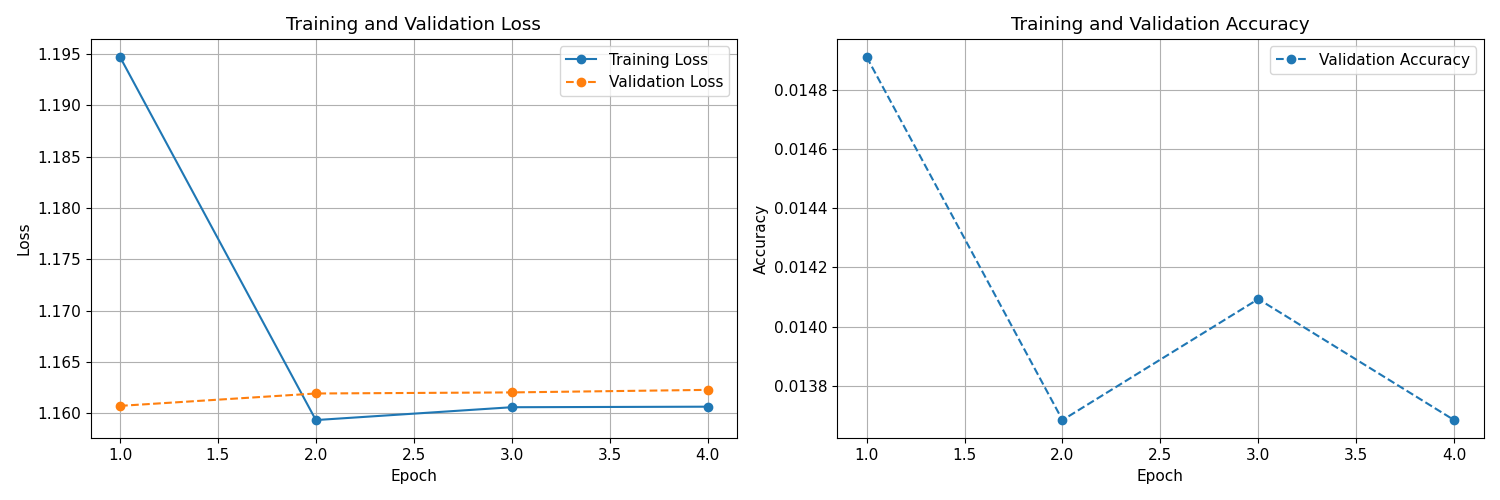

From the plot, it is clear that the loss does not improve, and by a check on the weights of the network the model has come across vanishing gradient.\
The model Stopped Early at the fourth epoch as the validation accuracy has been below the best three times in a row.
I tried different counter measures, such as
 - learning rate fine tuning, with values 1e-4, 5e-4 and 1e-3
 - weight initialization on the MLP
 - double check of all normalizations in the process
 - checked and tried different loss function (EIoU, CIoU)
 - applied batch normalization in the MLP
 - running the model with the not-pretrained class and ideal weight initialization

However, the result was always a vanishing gradients, with loss function showing no enhance. 
As a result, CustomModel greately underperforms the basemodel.\
As I have not been able to find a solution, if possible I would like to discuss improvements on this during the discussion. 